### REFERENCES:
  1. Creating more training data
    * (https://datascience.stackexchange.com/questions/5224/how-to-prepare-augment-images-for-neural-network)
  2. Preprocess, Feature Extract, Learn/Train, Classification (Pt. 3 - 6)
    * https://github.com/mesargent/freeway_guide_sign_detector/blob/master/contour_HOG_SVM_pipeline.ipynb

# Gate detection pipeline

  1. crop
  2. duplicate
    * reshape
    * blur?
    * transform (between -10 and 10 pixels) [1]
    * rotate [1]
    * flipping [1]
  3. preprocess [2]
    * filter out blue
      * max 255 - 50 for red and yellow
      * filter out blue - leave some no more than 100 test
    * apply threshold
    * find contours
    * calculate/find gate/bars (the more the better)
  4. feature extraction [2]
    * get features from HOG
  5. learn [2]
    * train SVM with HOG features 
  6. classification [2]
    * feed boxed images to trained SVM
    * use non gate images to test classifier

In [2]:
import cv2
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix
import os
from matplotlib import pyplot as plt
%matplotlib inline

### 1. Crop images

In [3]:
## work-in-prograss

### 2. Duplicate

In [4]:
# transform, etc..

### 3. Preprocess

*useful functions*

In [5]:

def resize(img, scale): # resize image to scale value param
    return cv2.resize(img, (int(img.shape[1] * scale), int(img.shape[0] * scale) ) )


def scaled(img, scale): # returns new scale value
    img_shape_x, img_shape_y, channels = img.shape
    if img_shape_x > scale:
        return scale / img_shape_x
    else:
        return 1
    

def preprocess(image, lower_upper_list): # 2nd param now takes a list to handle python3
    lower = np.array(lower_upper_list[0], dtype="uint8")
    upper = np.array(lower_upper_list[1], dtype="uint8")
    
    mask = cv2.inRange(image, lower, upper)
    output = cv2.bitwise_and(image, image, mask = mask)
    
    return output, mask


*sample images/video path*

In [7]:
img2_path = "../tmp_files/third_run/front09.jpg" # had to get a little creative to find this
img1_path = "../tmp_files/fourth_run/front55.jpg" # gate detection was easier - all 3 bars

*import images*

In [9]:
img1 = cv2.imread(img1_path)
img2 = cv2.imread(img2_path)
print("image 1 shape:", img1.shape )
print("image 2 shape:", img2.shape )

image 1 shape: (480, 744, 3)
image 2 shape: (480, 744, 3)


###  *filter out blues*

In [10]:
#lower_blue = np.array([0, 0, 0]) # good result values
lower_blue = np.array([55, 55, 55]) # for testing

#upper_blue = np.array([130, 255, 255]) # good result values
upper_blue = np.array([150, 255, 255]) # for testing

pimage1, mask = preprocess(img1, [ lower_blue, upper_blue ])
pimage2, mask = preprocess(img2, [ lower_blue, upper_blue ])

*to grayscale*

In [11]:
img1_gray = cv2.cvtColor(pimage1, cv2.COLOR_BGR2GRAY)
img2_gray = cv2.cvtColor(pimage2, cv2.COLOR_BGR2GRAY)

### *apply threshold*

In [12]:
#ret1, img1_thresh = cv2.threshold(img1_gray, 127, 255, 0 )
ret1, img1_thresh = cv2.threshold(img1_gray, 127, 255, cv2.THRESH_TOZERO )

#ret2, img2_thresh = cv2.threshold(img2_gray, 127, 255, 0 )
ret2, img2_thresh = cv2.threshold(img2_gray, 127, 255, cv2.THRESH_TOZERO )

### *find contours*

In [13]:
img1_c, img1_contours, img1_heirarchy = cv2.findContours(img1_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
img2_c, img2_contours, img2_heirarchy = cv2.findContours(img2_thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

*filter contours*

In [14]:
# not used

def contours_filter(img_contours):
    new_contour_list = []
    for cont in img_contours:
        if len(cont) > 20 and len(cont) < 200:
            new_contour_list.append(cont)
    return np.array(new_contour_list)

*useful bounding box functions*

In [15]:
def create_all_boxes(img_contours_list): # takes in a list of contour coordinates and returns an list of boxes around contours
    box_list = []
    for contour in img_contours_list:
        cv2.boundingRect(contour)
        box_list.append(contour)
    return box_list

def filter_boxes(img_rectangle_list, filter_size=0):
    filtered_boxes = []
    for rectangle in img_rectangle_list:
        if(rectangle[2] * rectangle[3] > filter_size):
            filtered_boxes.append(rectangle)
    return filtered_boxes

def draw_rectangles(img, img_rectangle_list, x_offset=0, y_offset=0):
    for x, y, w, h in img_rectangle_list:
        cv2.rectangle(
            img,
            (x - x_offset, y - y_offset),
            ( (x + x_offset) + w, (y + y_offset) + h),
            (0, 255, 0),
            2
        )

### *calculate/find gate/bars (the more the better)*

In [16]:
cpy1 = img1.copy()
rgb1 = rgb1 = cv2.cvtColor(cpy1, cv2.COLOR_BGR2RGB)

cpy2 = img2.copy()
rgb2 = rgb2 = cv2.cvtColor(cpy2, cv2.COLOR_BGR2RGB)

In [17]:
box_filter_size = 400

*get all boxes and filter them*

In [20]:
''' ------------- img-1 ------------- '''
img1_all_boxes = [cv2.boundingRect(c) for c in img1_contours]
#img1_all_boxes = create_all_boxes(img1_contours) # doesn't work... idk why
#print("Image 1 number of boxes:", len(img1_all_boxes) )

img1_filter_boxes = filter_boxes(img1_all_boxes, box_filter_size)
#print("Image 1 number of filtered boxes over size", box_filter_size, ":", len(img1_filter_boxes) )

''' ------------- img-2 ------------- '''
img2_all_boxes = [cv2.boundingRect(c) for c in img2_contours]
#img2_all_boxes = create_all_boxes(img2_contours) # doesn't work... idk why
#print("Image 2 number of boxes:", len(img2_all_boxes) )

img2_filter_boxes = filter_boxes(img2_all_boxes, box_filter_size)
#print("Image 2 number of filtered boxes over size", box_filter_size, ":", len(img2_filter_boxes) )

*draw boxes on images*

In [21]:
## COMMENTED OUT FOR WORK IN PT. 4 - END BELOW

'''
draw_rectangles(rgb1, [img1_filter_boxes[1]], 5, 5)
draw_rectangles(rgb2, img2_filter_boxes, 5, 5)

plt.figure(figsize=(10, 6) )
plt.imshow(rgb1)
plt.show()

plt.figure(figsize=(10, 6) )
plt.imshow(rgb2)
plt.show()
'''
print()

In [23]:
## Notes for 11/17/2017 meeting
# houghtransform
# Canny
# aspect ratio - divisible by eight
# test limit of svm - start small amount of images


### 4. Feature Extraction

*useful directory extraction/info methods*

In [24]:
# returns a list of file names in a directory: cwd is default
def get_dir_list(imgs_path):
    dir_list = []
    with os.scandir(imgs_path) as it: # from python3 docs
        for entry in it:
            if not entry.name.startswith(".") and entry.is_file:
                dir_list.append(imgs_path + entry.name)
    return dir_list

def get_img_data(imgs_path):
    img_list = []
    for img in imgs_path:
        img_list.append(cv2.imread(img) )
    return img_list

def get_features_with_label(image_data, hog, dimensions, label):
    data = []
    for img in image_data:
        image = cv2.resize(img, dimensions) # resize to proportion might help
        feats = hog.compute(image[:, :, 2])
        data.append((feats, label) )
    return data

*get files from directory*

In [25]:
pos_image_path = "positive/"
neg_image_path = "negative/"

pos_img_list = get_dir_list(pos_image_path)
neg_img_list = get_dir_list(neg_image_path)

positive_images = get_img_data(pos_img_list)
negative_images = get_img_data(neg_img_list)

Define HOG params/descriptor

In [26]:
min_dim = 80
block_size = (16, 16)
block_stride = (8, 8)
cell_size = (8, 8)
bins = 9

dimensions = (min_dim, min_dim)

hog = cv2.HOGDescriptor(dimensions, block_size, block_stride, cell_size, bins)

Extract features and assign labels

In [27]:
p_images = get_features_with_label(positive_images, hog, dimensions, 1) # 1 is positive images
n_images = get_features_with_label(negative_images, hog, dimensions, 0) # 0 is negative images

In [28]:
print("Number of POSITIVE image features:", len(p_images) )
print("Number of NEGATIVE images features:", len(n_images) )

Number of POSITIVE image features: 59
Number of NEGATIVE images features: 145


## 5. Learn

*combine positive and negative features and shuffle*

In [29]:
imgs_df = p_images + n_images
np.random.shuffle(imgs_df) # shuffle
print("Total # of features:", len(imgs_df) )

Total # of features: 204


*split date in to testing/training sets*

In [30]:
feat, labels = map(list, zip(*imgs_df) )
feat_flat = [x.flatten() for x in feat]

X_df = pd.DataFrame(feat_flat) # convert to df
y_df = pd.Series(labels) # convert to series

X_train, X_test, y_train, y_test = train_test_split(X_df, y_df, test_size=0.3, random_state=2)

print("Feature TRAINING data", X_train.shape)
print("Feature TESTING data ", X_test.shape)
print("Label TRAINING data  ", y_train.shape)
print("Label TESTING data   ", y_test.shape)


Feature TRAINING data (142, 2916)
Feature TESTING data  (62, 2916)
Label TRAINING data   (142,)
Label TESTING data    (62,)


*train svm*

In [31]:
svm_l = SVC(kernel="linear", C = 1.0, probability=True, random_state=2)
svm_l.fit(X_train, y_train)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=2, shrinking=True, tol=0.001,
  verbose=False)

In [32]:
print(svm_l.score(X_train, y_train) )

1.0


In [33]:
print("Test Accuracy:", svm_l.score(X_test, y_test) )
y_pred = svm_l.predict(X_test)
print("\nClassification report")
print(classification_report(y_test, y_pred) )

Test Accuracy: 1.0

Classification report
             precision    recall  f1-score   support

          0       1.00      1.00      1.00        42
          1       1.00      1.00      1.00        20

avg / total       1.00      1.00      1.00        62



*number of misclassified images*

In [38]:
wrong = (y_pred != y_test).sum()
print("Misclassified images:", wrong)

Misclassified images: 0


In [39]:
confusion_matrix(y_pred, y_test)

array([[42,  0],
       [ 0, 20]])

### 6. Classification

*check features*

In [40]:
def get_positive_roi(img, roi_list, x_offset=0, y_offset=0):
    positive_roi = []
    for x, y, w, h in roi_list:
        roi = img[y:y + h, x:x + w, :3]
        roi_resized = cv2.resize(roi, dimensions) # dimensions defined as (80, 80) above
        features = hog.compute(roi_resized)
        proba = svm_l.predict_proba(features.reshape(1, -1) )[0] # will produce meaningless results on very small datasets per docs
        if proba[1] > .1:
            positive_roi.append((x, y, w, h) )
    return positive_roi

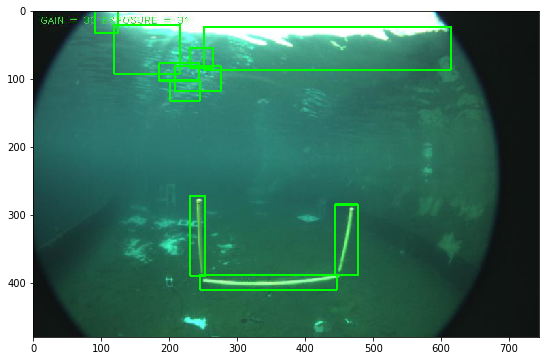

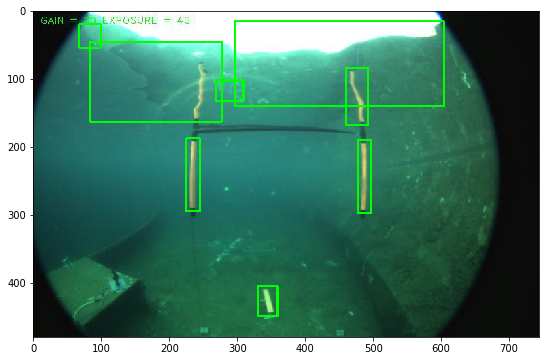

In [41]:
# Split all this below in to different cells for testing


img1_all_boxes = [cv2.boundingRect(c) for c in img1_contours]
img1_filter_boxes = filter_boxes(img1_all_boxes, box_filter_size)

roi_filtered_1 = get_positive_roi(rgb1, img1_filter_boxes)
draw_rectangles(rgb1, roi_filtered_1, 5, 5)

plt.figure(figsize=(10, 6) )
plt.imshow(rgb1)
plt.show()


img2_all_boxes = [cv2.boundingRect(c) for c in img2_contours]
img2_filter_boxes = filter_boxes(img2_all_boxes, box_filter_size)

roi_filtered_2 = get_positive_roi(rgb2, img2_filter_boxes)
draw_rectangles(rgb2, roi_filtered_2, 5, 5)

plt.figure(figsize=(10, 6) )
plt.imshow(rgb2)
plt.show()

print()

# END